### Лабораторная работа 6. Обучение без учителя. Понижение размерности

#### Задачи:




In [448]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes  # подключаем датасет из sklearn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import scipy.stats as stats

from sklearn import datasets
from sklearn.decomposition import PCA

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.decomposition import KernelPCA



#### Описание датасета:
Для анализа используется датасет "weather_classification_data", который включает в себя различные характеристики, связанные с погодой, и классифицирует погоду по четырем типам: дождливая, солнечная, облачная и снежная.

- **Temperature (numeric):** температура в градусах Цельсия, от экстремально низкой до экстремально высокой температуры.
- **Humidity (numeric):** процент влажности, включая значения выше 100% для введения выбросов.
- **Wind Speed (numeric):** скорость ветра в километрах в час, с диапазоном, включающим нереалистично высокие значения.
- **Precipitation (%) (numeric):** процент осадков, включая значения выбросов.
- **Cloud Cover (categorical):** описание облачного покрова.
- **Atmospheric Pressure (numeric):** атмосферное давление в гПа, охватывающее широкий диапазон.
- **UV Index (numeric):** УФ-индекс, указывающий силу ультрафиолетового излучения.
- **Season (categorical):** сезон, в течение которого были записаны данные.
- **Visibility (km) (numeric):** видимость в километрах, включая очень низкие или очень высокие значения.
- **Location (categorical):** тип местоположения, в котором были записаны данные.
- **Weather Type (categorical):** целевая переменная для классификации, указывающая тип погоды.


In [449]:
df = pd.read_csv('weather_classification_data.csv')
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


#### Общие статистические данные

Размер датасета

In [450]:
df.shape

(13200, 11)

Проверим на пропуски

In [451]:
df.isnull().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

Пропусков нет! И хорошо)

Информация о столбцах и типах данных в них

In [452]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [453]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


In [454]:
df.describe(include='object')

,Cloud Cover,Season,Location,Weather Type
count,13200,13200,13200,13200
unique,4,4,3,4
top,overcast,Winter,inland,Rainy
freq,6090,5610,4816,3300


Проверим категориальные данные на допустимые значения

In [455]:
df['Cloud Cover'].unique()


array(['partly cloudy', 'clear', 'overcast', 'cloudy'], dtype=object)

In [456]:
df['Season'].unique()


array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

In [457]:
df['Location'].unique()


array(['inland', 'mountain', 'coastal'], dtype=object)

In [458]:
df['Weather Type'].unique()


array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

Всё чисто

In [459]:
df['Weather Type'].value_counts()

Weather Type
Rainy     3300
Cloudy    3300
Sunny     3300
Snowy     3300
Name: count, dtype: int64

Набор идеально сбалансирован. Сказывается его синтетичность

Очистим от выбросов!


In [460]:
def remove_outliers(df):
    cleaned_df = df.copy()
    for col in cleaned_df.columns:
        if cleaned_df[col].dtype in ['float64', 'int64']:

            Q1 = cleaned_df[col].quantile(0.25)
            Q3 = cleaned_df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR

            cleaned_df[col] = cleaned_df[col].apply(
                lambda x: x if pd.isnull(x) or (lower_limit <= x <= upper_limit) else None
            )
    
    return cleaned_df

df = remove_outliers(df)

percent_nulos = df.isnull().mean() * 100
print(percent_nulos)

Temperature             0.696970
Humidity                0.000000
Wind Speed              3.060606
Precipitation (%)       0.000000
Cloud Cover             0.000000
Atmospheric Pressure    7.022727
UV Index                0.000000
Season                  0.000000
Visibility (km)         2.901515
Location                0.000000
Weather Type            0.000000
dtype: float64


И заменим полученный NaN

In [461]:
def replace_nulls(df):
    for column in df.columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame. Skipping...")
            continue
        if df[column].dtype == 'object':                   # Categorical column
            mode = df[column].mode()[0]                    # Calculate mode
            df[column] = df[column].fillna(mode)
        else:                                              # Numeric column
            mean = df[column].mean()                       # Calculate mean
            df[column] = df[column].fillna(mean)
    return df

df = replace_nulls(df)


Переведём категориальные признаки

In [462]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
res = enc.fit_transform(df[['Cloud Cover']])
df[enc.categories_[0]] = res.toarray()
res = enc.fit_transform(df[['Season']])
df[enc.categories_[0]] = res.toarray()
res = enc.fit_transform(df[['Location']])
df[enc.categories_[0]] = res.toarray()
df.drop(columns=['Cloud Cover', 'Season', 'Location'], inplace=True)

#from sklearn.preprocessing import OrdinalEncoder
#enc = OrdinalEncoder()
#df[['Weather Type']] = enc.fit_transform(df[['Weather Type']])
#df.head()


Выделяем все столбцы кроме целевого (они у нас все числовые теперь, так что гуд)

In [463]:
df_input = df.copy(deep=True)
df.drop(columns=['Wind Speed','UV Index','Weather Type', 'clear', 'cloudy', 'overcast',
                'partly cloudy', 'Autumn', 'Spring', 'Summer', 'Winter',
                'coastal', 'inland', 'mountain'], inplace=True)
df.head()


,Temperature,Humidity,Precipitation (%),Atmospheric Pressure,Visibility (km)
0,14.0,73,82.0,1010.82,3.5
1,39.0,96,71.0,1011.43,10.0
2,30.0,64,16.0,1018.72,5.5
3,38.0,83,82.0,1026.25,1.0
4,27.0,74,66.0,990.67,2.5


In [464]:
vals = df_input['Weather Type'].unique()
X = df
y = df_input['Weather Type'].replace(vals, [0, 1, 2, 3])
yvals = df_input['Weather Type']

In [465]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    print(f'RMSE:  {round(RMSE,4)}\n  R2: {round(R2,4)}\n Adjusted R2: {round(adjusted_r2, 4)}\n Cross Validated R2: {round(cv_score.mean(),4)}')
    return R2, adjusted_r2, CV_R2, RMSE

#### PCA

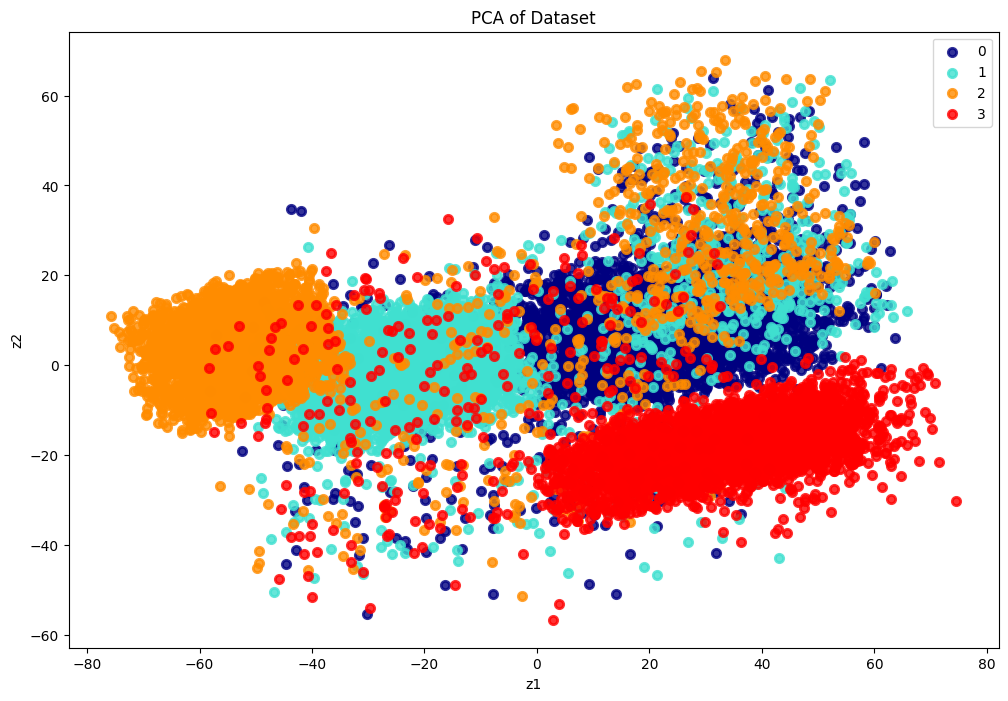

In [466]:
pca = PCA(n_components=3)
X_new = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
colors = ["navy", "turquoise", "darkorange",'red']
lw = 2

unique_vals = y.unique()
#Выводим
for color, i, target_name in zip(colors, unique_vals, unique_vals):
    plt.scatter(
        X_new[y == target_name, 0], X_new[y == target_name, 1], color=color, alpha=0.8, lw=lw, label=target_name )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("PCA of Dataset")
plt.show()


Есть явные скопления данных и наблюдается тренд

In [467]:
pca.explained_variance_ratio_

array([0.70781216, 0.14672826, 0.1073539 ])

#### ICA

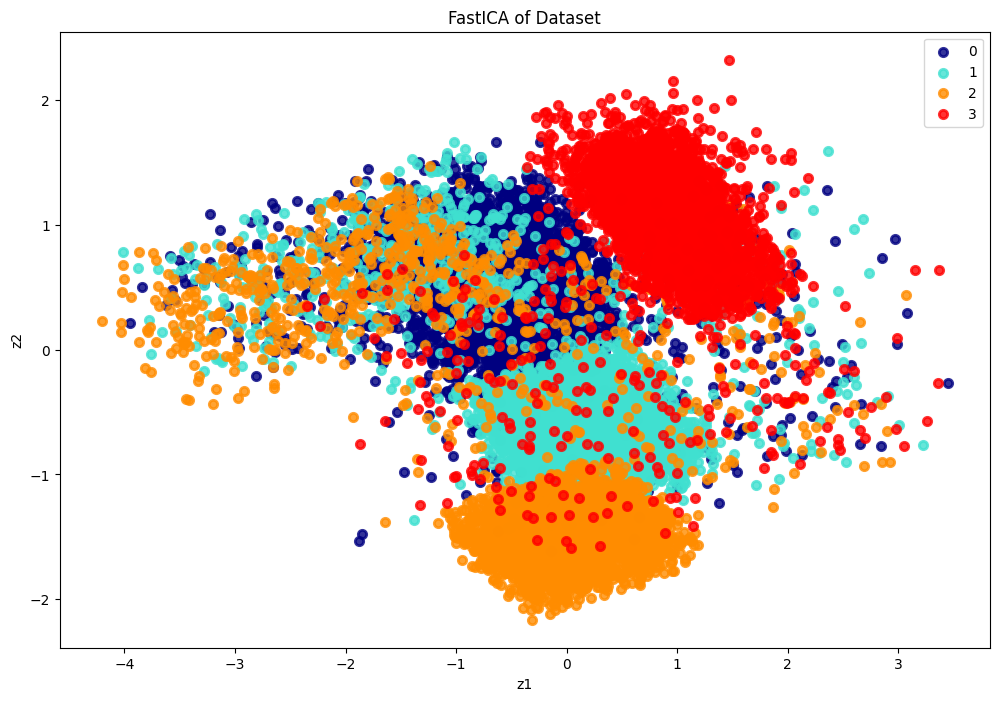

In [468]:
from sklearn.decomposition import FastICA
#Применяем ICA
fast_ica = FastICA(n_components=2)
X_new = fast_ica.fit_transform(X)

plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange",'red','blue',"green"]
lw = 2
unique_vals = y.unique()

for color, i, target_name in zip(colors, unique_vals, unique_vals):
    plt.scatter(
        X_new[y == target_name, 0], X_new[y == target_name, 1], color=color, alpha=0.8, lw=lw, label=target_name )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("FastICA of Dataset")
plt.show()

KernelPCA

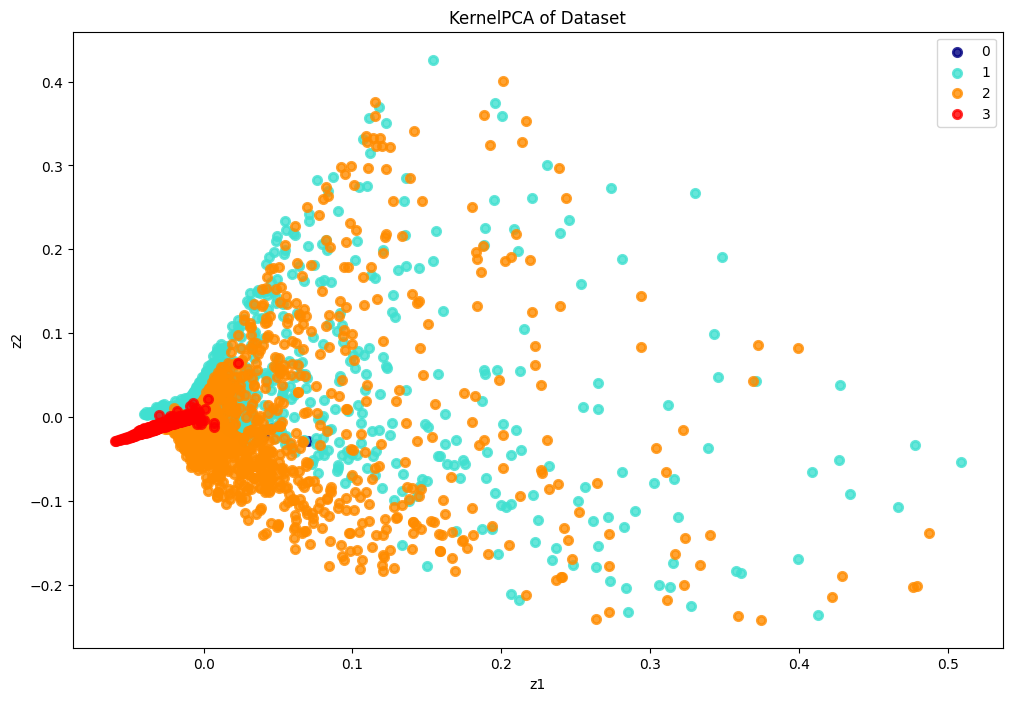

In [469]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.05)
X_new = rbf_pca.fit_transform(X)

plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange",'red','blue',"green"]
lw = 2

unique_vals = y.unique()

for color, i, target_name in zip(colors, unique_vals, unique_vals):
    plt.scatter(
        X_new[y == target_name, 0], X_new[y == target_name, 1], color=color, alpha=0.8, lw=lw, label=target_name )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("KernelPCA of Dataset")
plt.show()

tSNE

Прежняя размерность:  (13200, 5)
Новая размерность:  (13200, 2)
Расхождение Кульбака-Лейблера после оптимизации:  1.5500408411026
Количество иттераций:  999


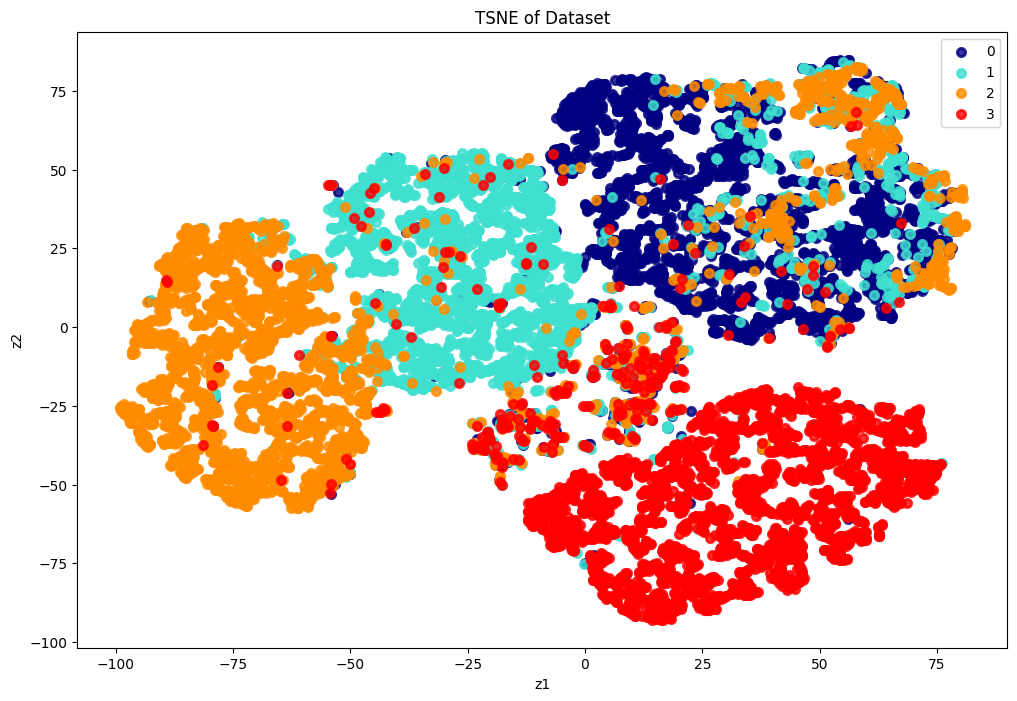

In [470]:
from sklearn.manifold import TSNE
#Применяем TNSE
tsne = TSNE(n_components=2)
X_new = tsne.fit_transform(X)
# Вывод результатов
print('Прежняя размерность: ', X.shape)
print('Новая размерность: ', X_new.shape)
print('Расхождение Кульбака-Лейблера после оптимизации: ', tsne.kl_divergence_)
print('Количество иттераций: ', tsne.n_iter_)

plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange",'red','blue',"green"]
lw = 2
unique_vals = y.unique()

for color, i, target_name in zip(colors, unique_vals, unique_vals):
    plt.scatter(
        X_new[y == target_name, 0], X_new[y == target_name, 1], color=color, alpha=0.8, lw=lw, label=target_name )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("TSNE of Dataset")
plt.show()

Здесь ситуация явно хорошая. Есть три сильно зашумлённых кластера, но также присутствуют три достаточно чистых

In [471]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
#Применяем DBSCAN с некоторыми произвольным параметром eps
dbscan_cluster1 = DBSCAN(eps = 0.28, min_samples = 3)
X_new = dbscan_cluster1.fit(X)

In [472]:
#Выводим данные о работе DBSCAN
labels=dbscan_cluster1.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Количество кластеров: %d' % N_clus)
n_noise = list(dbscan_cluster1.labels_).count(-1)
print('Количество шумов: %d' % n_noise)

print('v_measure =', v_measure_score(y, labels))

Количество кластеров: 0
Количество шумов: 13200
v_measure = 0.0


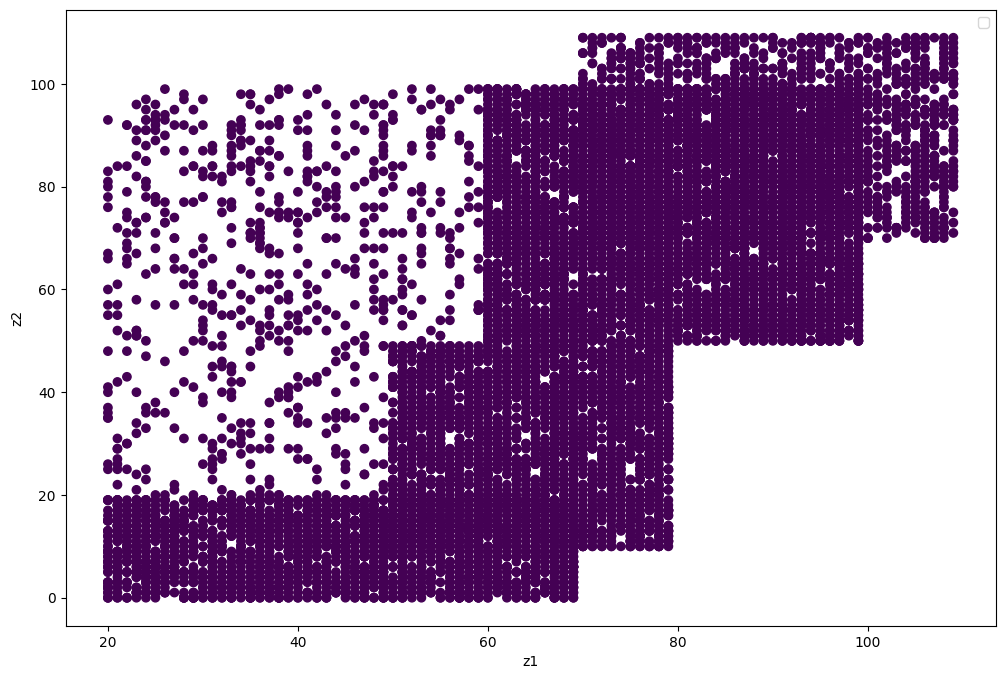

In [473]:
plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange",'red','blue',"green"]
lw = 2

plt.scatter(
        X[df.columns[1]], X[df.columns[2]],c=dbscan_cluster1.labels_
    )

plt.legend(loc="best", shadow=False, scatterpoints=2)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

#С такими начальными параметрами получается очень плохое разделение и множество выбросов

In [474]:
#Методом локтя находим лучшее значение eps
from sklearn.neighbors import NearestNeighbors
import sklearn
min_samples = 3

knn = NearestNeighbors(n_neighbors = min_samples, metric = 'l2')
knn.fit(X)

dists, inds = knn.kneighbors(X)
dists_ar = dists[:, 1:min_samples].mean(axis=1)
dists_ar.sort()
sklearn.metrics.pairwise.distance_metrics()

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'precomputed': None,
 'nan_euclidean': <function sklearn.metrics.pairwise.nan_euclidean_distances(X, Y=None, *, squared=False, missing_values=nan, copy=True)>}

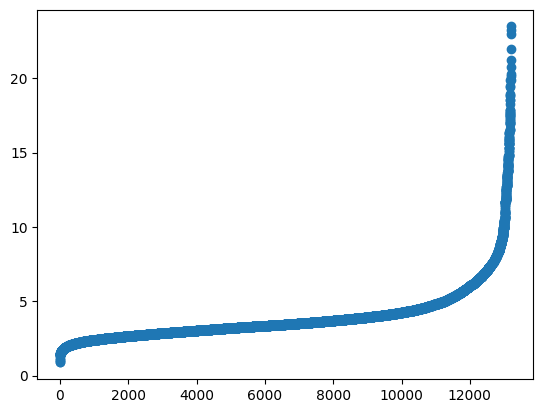

In [475]:
plt.scatter(x = range(len(dists_ar)), y=dists_ar)
plt.show()

#Наилучшее значение eps находится в пределах от 0.5 до 1.5

In [511]:
#Методом подбора находим лучшее значение eps
dbscan = DBSCAN(eps = 5.9, min_samples = 18)
print(dbscan)
pred = dbscan.fit_predict(X)
#Выводим новые значения работы DBSCAN
labels=dbscan.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Количество кластеров: %d' % N_clus)
n_noise = list(dbscan.labels_).count(-1)
print('Количество шумов: %d' % n_noise)

print('v_measure =', v_measure_score(y, labels))


DBSCAN(eps=5.9, min_samples=18)
Количество кластеров: 10
Количество шумов: 5310
v_measure = 0.49499413582570545


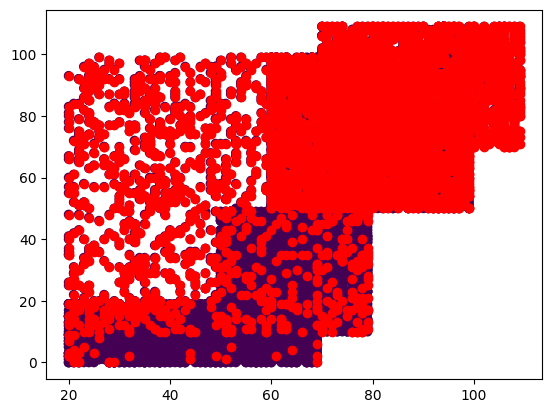

In [512]:

anom_index = [i for i in range(len(pred)) if pred[i] == -1]
values = X.loc[anom_index]
plt.scatter( X[df.columns[1]], X[df.columns[2]],c=dbscan_cluster1.labels_)
plt.scatter(values[df.columns[1]], values[df.columns[2]], color='r')
plt.show()

По всей видимости, набор должен был быть разбит на 4 категории, как оно и есть. В датасете наблюдается много шумов, или незначащих значений, очень много наложений